In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as pp
import os
from PIL import Image
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from matplotlib import pyplot as pp
from sklearn.tree import plot_tree
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    ConfusionMatrixDisplay
)

In [2]:
data = pd.read_csv('~/AAI-510/Final Project/Data/diamond_data.csv')
data.drop(columns=['path_to_img','stock_number'],inplace=True) #Not required for regression task
data

,shape,carat,clarity,colour,cut,polish,symmetry,fluorescence,lab,length,width,depth
0,cushion,0.55,SI2,N,VG,EX,VG,N,GIA,4.56,4.44,3.09
1,cushion,0.52,SI2,Y-Z,EX,EX,VG,F,GIA,4.40,4.31,2.99
2,cushion,0.50,SI1,L,VG,EX,VG,N,GIA,4.87,4.19,2.89
3,cushion,0.50,VS2,M,EX,EX,VG,F,GIA,4.73,4.28,2.84
4,cushion,0.51,SI1,M,EX,EX,VG,N,GIA,4.47,4.44,3.05
...,...,...,...,...,...,...,...,...,...,...,...,...
48760,round,4.40,VVS1,E,EX,EX,EX,F,GIA,10.34,10.41,6.48
48761,round,4.40,IF,D,EX,EX,EX,N,GIA,10.49,10.55,6.47
48762,round,5.01,VVS2,D,EX,EX,EX,N,GIA,10.89,10.95,6.73
48763,round,5.19,FL,D,EX,EX,EX,N,GIA,11.16,11.22,6.77


In [3]:
print(data.isnull().sum())

#Since we have relatively lower number of NaNs, it is just better to drop the rows with NaN values
data.dropna(inplace=True)

shape              0
carat              0
clarity           38
colour             0
cut             1015
polish             2
symmetry           2
fluorescence       0
lab                0
length             0
width              0
depth              0
dtype: int64


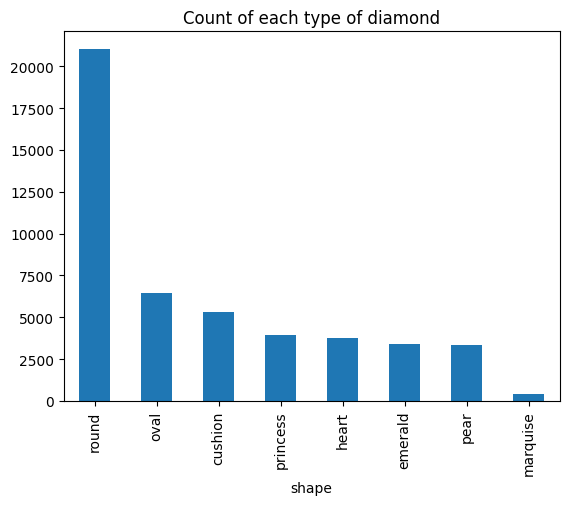

In [4]:
data['shape'].value_counts().plot(kind='bar')
pp.title('Count of each type of diamond')
pp.show()

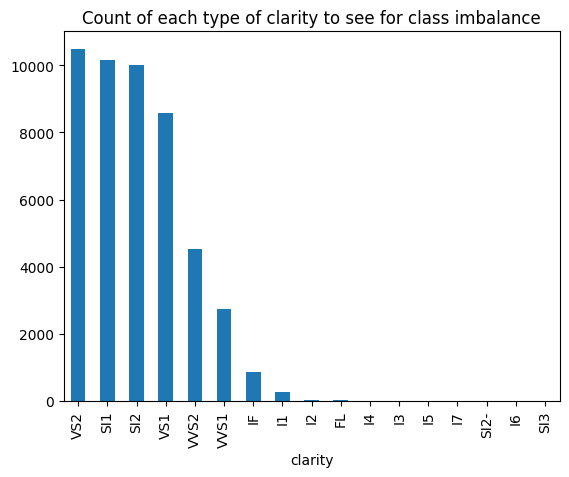

In [5]:
data['clarity'].value_counts().plot(kind='bar')
pp.title('Count of each type of clarity to see for class imbalance')
pp.show()

In [6]:
#As one can see, there are many categories which have negligible samples. The model obviously will not perform well on these by themselves.
#Instead, we will group them into one category called Other.

group = data['clarity'].value_counts()

to_group = group[group < 3000].index

data['clarity'][data['clarity'].isin(to_group)] = 'Other'

C:\Users\Shreyas\AppData\Local\Temp\ipykernel_58724\472250796.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['clarity'][data['clarity'].isin(to_group)] = 'Other'


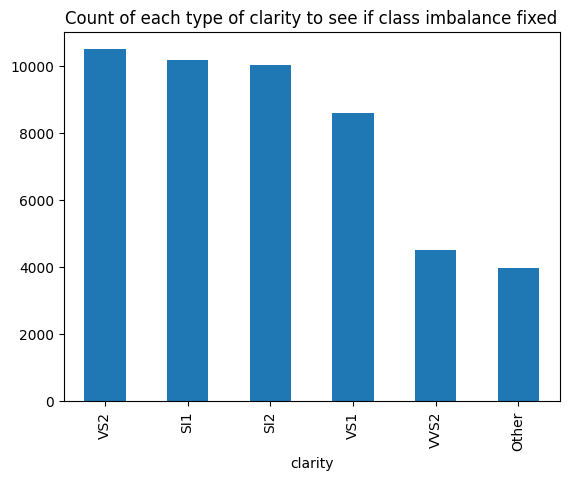

In [7]:
data['clarity'].value_counts().plot(kind='bar')
pp.title('Count of each type of clarity to see if class imbalance fixed')
pp.show()

In [8]:
#Encoding the categorical features
encoder = OrdinalEncoder() #We dont use one hot encoding to avoid extra dimensions which cause problems for Decision tree based algorithms
col_enc = data.select_dtypes(include=['object', 'category']).columns #Only the categorical columns
data[col_enc] = encoder.fit_transform(data[col_enc])

In [9]:
X = data.drop(columns=['clarity'])
y = data['clarity']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

To just compare, the training accuracy is:  0.3321543661086222
Testing Accuracy is:  0.31520486220266164
Precision score is:  0.3007878071714515
Recall score is:  0.31520486220266164
F1 score is:  0.28020234113991577
The classification report:

              precision    recall  f1-score   support

         0.0       0.30      0.06      0.10       776
         1.0       0.29      0.27      0.28      2045
         2.0       0.45      0.49      0.47      1977
         3.0       0.26      0.13      0.18      1728
         4.0       0.27      0.57      0.37      2116
         5.0       0.15      0.01      0.01       901

    accuracy                           0.32      9543
   macro avg       0.29      0.25      0.23      9543
weighted avg       0.30      0.32      0.28      9543



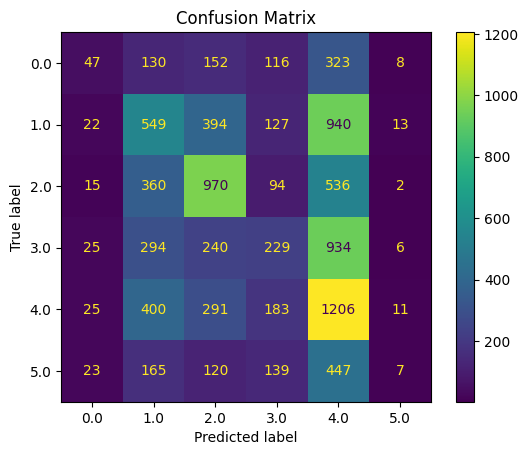

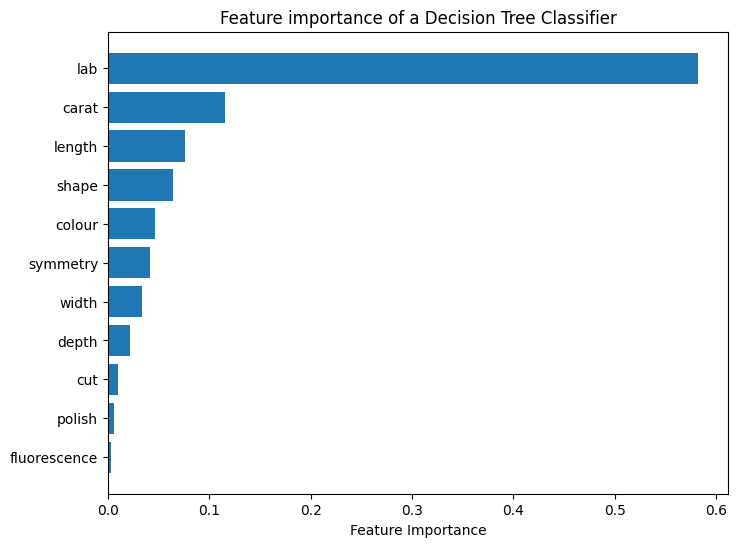

In [10]:
#Model 1, Decision Tree Classifier

model = DecisionTreeClassifier(max_depth=8,min_samples_split=20,min_samples_leaf=5,random_state=42)
model.fit(X_train,y_train)

y_pred1 = model.predict(X_test)

print("To just compare, the training accuracy is: ",accuracy_score(y_train,model.predict(X_train)))
print("Testing Accuracy is: ",accuracy_score(y_test,y_pred1))
print("Precision score is: ",precision_score(y_test,y_pred1,average='weighted'))
print("Recall score is: ",recall_score(y_test,y_pred1,average='weighted'))
print("F1 score is: ",f1_score(y_test,y_pred1,average='weighted'))
print("The classification report:\n")
print(classification_report(y_test,y_pred1))

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

pp.title("Confusion Matrix")
pp.show()

importances = model.feature_importances_ #let's look at feature importance too to get a gauge of how the variables are explaining the Y
feature_names = X_train.columns
# Sort importances
index = np.argsort(importances)

pp.figure(figsize=(8, 6))
pp.barh(range(len(importances)), importances[index], align='center')
pp.yticks(range(len(importances)), [feature_names[i] for i in index])
pp.xlabel("Feature Importance")
pp.title("Feature importance of a Decision Tree Classifier")
pp.show()

#plot_tree(model,filled=True,max_depth=2,feature_names=X.columns)

In [11]:
#Since a few features have shown negligible importance wrt Y
#We will drop those features in an attempt to improve performance.
X_train_t = X_train.copy()
X_test_t = X_test.copy()
X_train.drop(columns=['fluorescence','polish','cut','depth','width'],inplace=True)
X_test.drop(columns=['fluorescence','polish','cut','depth','width'],inplace=True)

To just compare, the training accuracy is:  0.3911289266158401
Testing Accuracy is:  0.3239023367913654
Precision score is:  0.3215883650838915
Recall score is:  0.3239023367913654
F1 score is:  0.2988636855018984
The classification report:

              precision    recall  f1-score   support

         0.0       0.36      0.06      0.11       776
         1.0       0.29      0.36      0.32      2045
         2.0       0.46      0.47      0.47      1977
         3.0       0.27      0.20      0.23      1728
         4.0       0.29      0.48      0.36      2116
         5.0       0.23      0.02      0.03       901

    accuracy                           0.32      9543
   macro avg       0.32      0.27      0.25      9543
weighted avg       0.32      0.32      0.30      9543



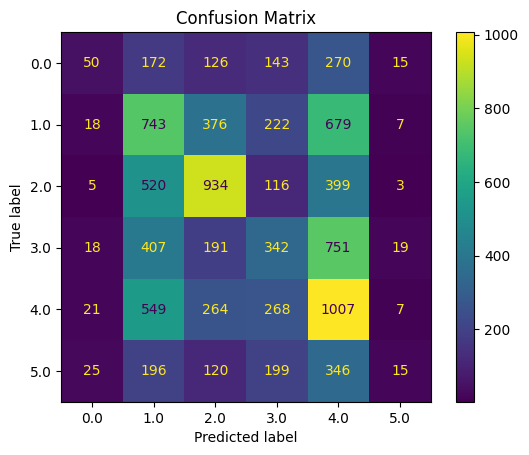

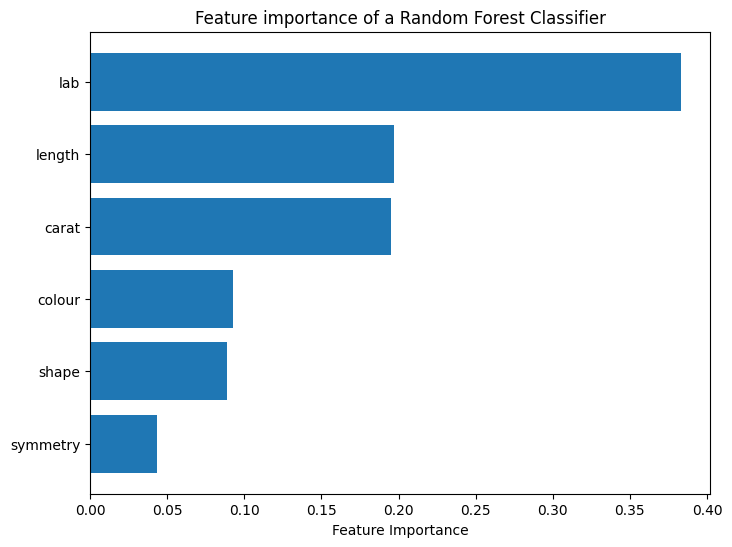

In [12]:
#Model 2, Random Forest Classifier

model = RandomForestClassifier(max_depth=10,min_samples_split=10,min_samples_leaf=5,random_state=42)
model.fit(X_train,y_train)

y_pred2 = model.predict(X_test)

print("To just compare, the training accuracy is: ",accuracy_score(y_train,model.predict(X_train)))
print("Testing Accuracy is: ",accuracy_score(y_test,y_pred2))
print("Precision score is: ",precision_score(y_test,y_pred2,average='weighted'))
print("Recall score is: ",recall_score(y_test,y_pred2,average='weighted'))
print("F1 score is: ",f1_score(y_test,y_pred2,average='weighted'))
print("The classification report:\n")
print(classification_report(y_test,y_pred2))

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

pp.title("Confusion Matrix")
pp.show()

importances = model.feature_importances_ 
feature_names = X_train.columns

index = np.argsort(importances)

pp.figure(figsize=(8, 6))
pp.barh(range(len(importances)), importances[index], align='center')
pp.yticks(range(len(importances)), [feature_names[i] for i in index])
pp.xlabel("Feature Importance")
pp.title("Feature importance of a Random Forest Classifier")
pp.show()

#plot_tree(model,filled=True,max_depth=2,feature_names=X.columns)

To just compare, the training accuracy is:  0.4063769027221043
Testing Accuracy is:  0.3270460023053547
Precision score is:  0.32244630052331863
Recall score is:  0.3270460023053547
F1 score is:  0.31278476236643693
The classification report:

              precision    recall  f1-score   support

         0.0       0.31      0.13      0.18       776
         1.0       0.29      0.36      0.32      2045
         2.0       0.48      0.47      0.47      1977
         3.0       0.27      0.23      0.25      1728
         4.0       0.29      0.44      0.35      2116
         5.0       0.21      0.05      0.08       901

    accuracy                           0.33      9543
   macro avg       0.31      0.28      0.28      9543
weighted avg       0.32      0.33      0.31      9543



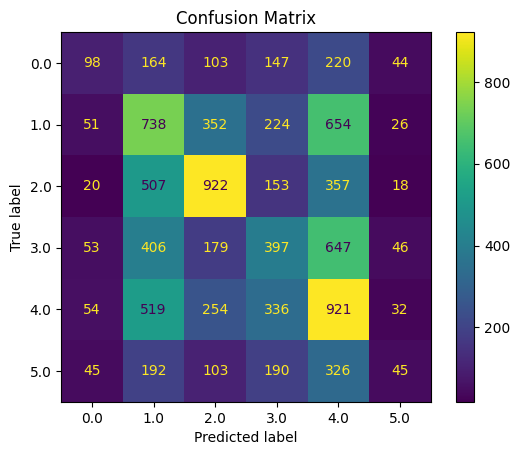

In [13]:
#Model 3, Gradient Boosting Classifier

model = GradientBoostingClassifier(max_depth=6,min_samples_split=10,min_samples_leaf=7,random_state=42,max_features='sqrt')
model.fit(X_train,y_train)

y_pred3 = model.predict(X_test)

print("To just compare, the training accuracy is: ",accuracy_score(y_train,model.predict(X_train)))
print("Testing Accuracy is: ",accuracy_score(y_test,y_pred3))
print("Precision score is: ",precision_score(y_test,y_pred3,average='weighted'))
print("Recall score is: ",recall_score(y_test,y_pred3,average='weighted'))
print("F1 score is: ",f1_score(y_test,y_pred3,average='weighted'))
print("The classification report:\n")
print(classification_report(y_test,y_pred3))

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

pp.title("Confusion Matrix")
pp.show()

#plot_tree(model,filled=True,max_depth=2,feature_names=X.columns)

To just compare, the training accuracy is:  0.38007283397521546
Testing Accuracy is:  0.3226448705857697
Precision score is:  0.3219539529844594
Recall score is:  0.3226448705857697
F1 score is:  0.30570820997976117
The classification report:

              precision    recall  f1-score   support

         0.0       0.28      0.11      0.15       776
         1.0       0.29      0.37      0.33      2045
         2.0       0.49      0.46      0.47      1977
         3.0       0.27      0.21      0.23      1728
         4.0       0.28      0.44      0.35      2116
         5.0       0.26      0.04      0.07       901

    accuracy                           0.32      9543
   macro avg       0.31      0.27      0.27      9543
weighted avg       0.32      0.32      0.31      9543



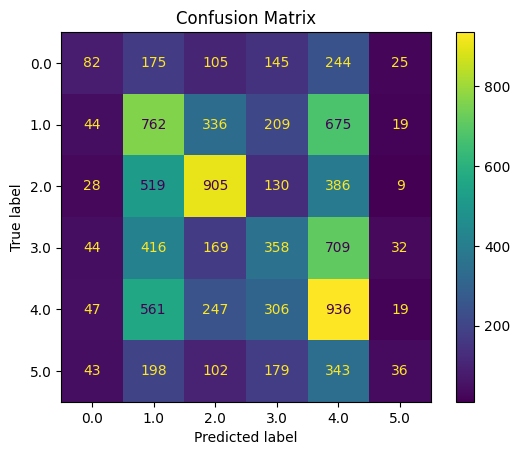

In [14]:
#Model 4, Gradient Boosting Classifier

model = XGBClassifier(n_estimators=1000,learning_rate=0.01,random_state=42)
model.fit(X_train,y_train)

y_pred4 = model.predict(X_test)

print("To just compare, the training accuracy is: ",accuracy_score(y_train,model.predict(X_train)))
print("Testing Accuracy is: ",accuracy_score(y_test,y_pred4))
print("Precision score is: ",precision_score(y_test,y_pred4,average='weighted'))
print("Recall score is: ",recall_score(y_test,y_pred4,average='weighted'))
print("F1 score is: ",f1_score(y_test,y_pred4,average='weighted'))
print("The classification report:\n")
print(classification_report(y_test,y_pred4))

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

pp.title("Confusion Matrix")
pp.show()

In [15]:
c=0
print("Legend for the ordinal encoding:\n")
for i in encoder.categories_[1]:
    print(c," : ",i)
    c = c + 1

Legend for the ordinal encoding:

0  :  Other
1  :  SI1
2  :  SI2
3  :  VS1
4  :  VS2
5  :  VVS2


As it is evident, the overall training AND testing accuracy are low. Through the heatmap of confusion matrix,
we can see that all models are showing similar performance to where they do well on class SI1,SI2 and VS2 but poorly on Other,VS1 and VVS2. Since simple decision tree has best performance, I will pick that for the analysis of results. A couple of potential reasons on poor performance could be:

1. Too simple a model
2. Features are not explaining the target well.
3. High amount of noise in the data
4. Class imbalance
5. Other types of relationships work better on the data


In [16]:
#Addressing 1
#I will increase the max depth to make the model more complex and see if that improves performance
#Since there is minimal class imbalance, just looking at accuracy will suffice to see if the alterations are improving performance

model = DecisionTreeClassifier(max_depth=14,min_samples_split=20,min_samples_leaf=5,random_state=42)
model.fit(X_train,y_train)

y_pred1 = model.predict(X_test)

print("To just compare, the training accuracy is: ",accuracy_score(y_train,model.predict(X_train)))
print("Testing Accuracy is: ",accuracy_score(y_test,y_pred1))
print("Precision score is: ",precision_score(y_test,y_pred1,average='weighted'))
print("Recall score is: ",recall_score(y_test,y_pred1,average='weighted'))
print("F1 score is: ",f1_score(y_test,y_pred1,average='weighted'))

#Increasing the max depth only led to overfitting as once can see from testing accuracy which decreased

To just compare, the training accuracy is:  0.4174591946343892
Testing Accuracy is:  0.2986482238289846
Precision score is:  0.2904586077618456
Recall score is:  0.2986482238289846
F1 score is:  0.2902713079565681


Addressing 2

Feature importance on the Decision tree classifier did show lower for a number of features
However, we dropped those features and refitted the later algorithms but did not observe an improvement in performance.

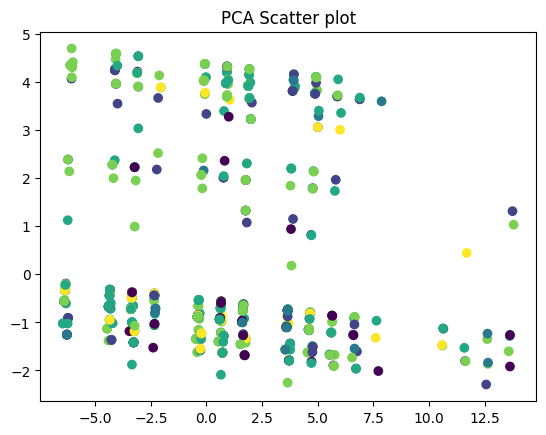

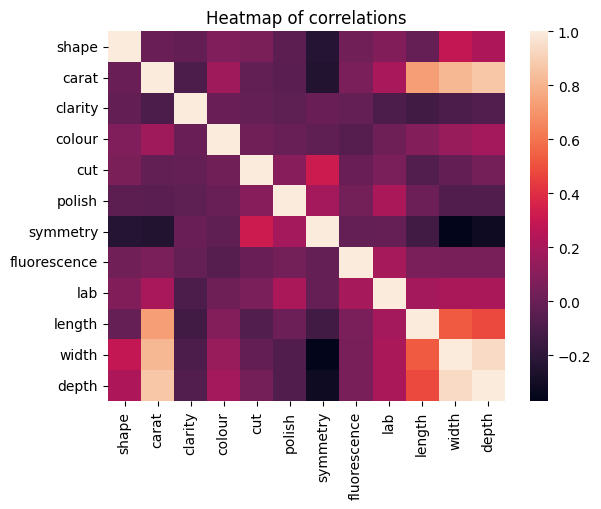

In [31]:
#Addressing 3
#I will create orthogonal independent PCA components from the features and see if there are overlaps
#if so, it will tell us that the data is noisy and there is class overlap which is making the performance suffer
from sklearn.decomposition import PCA
import seaborn as sn
pca = PCA(n_components=2)
comp = pca.fit_transform(X[:1000])

pp.scatter(comp[:,0], comp[:,1], c=y[:1000], cmap='viridis')
pp.title("PCA Scatter plot")
pp.show()
sn.heatmap(data.corr())
pp.title("Heatmap of correlations")
pp.show()
#There is overlap even in the first 1000 samples I selected. So this is one reason for the poor performance.
#The correlation is low across the board for clarity Y variable. It is good to note that there is some multicollinearity in the data
#So it is good we dropped those for later tree algorithms. Although it did not improve performance.

Addressing 4

We did check for class imbalance and while there was some initially, we tackled it by creating a dummy 'Other' class for classes with low count of data points


In [24]:
#Addressing 5
#Let us try to fit a multi class logistic regression, SVM and a basic Neural Network model
#None of these models showed significantly improved performance
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(64, 32),activation='relu',solver='adam',max_iter=1000,random_state=42)
#model = SVC(kernel='rbf', C=0.01, gamma='scale')  # RBF kernel by default
#model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000,random_state=42)
model.fit(X_train_t, y_train)

y_pred5 = model.predict(X_test_t)
print("To just compare, the training accuracy is: ",accuracy_score(y_train,model.predict(X_train_t)))
print("Testing Accuracy is: ",accuracy_score(y_test,y_pred5))
print("Precision score is: ",precision_score(y_test,y_pred5,average='weighted'))
print("Recall score is: ",recall_score(y_test,y_pred5,average='weighted'))
print("F1 score is: ",f1_score(y_test,y_pred5,average='weighted'))

To just compare, the training accuracy is:  0.33946396290183134
Testing Accuracy is:  0.3177197946138531
Precision score is:  0.31773451361133814
Recall score is:  0.3177197946138531
F1 score is:  0.2966262235182779
